# Jamboree, Event Sourcing, and Data Management Practices

## What is Event Sourcing?
The Event Sourcing pattern defines an approach to handling operations on data that's driven by a sequence of events, each of which is recorded in an append-only store. In essense, it's a **push** only operation in a line of ops. **Microsoft** has the diagram below:

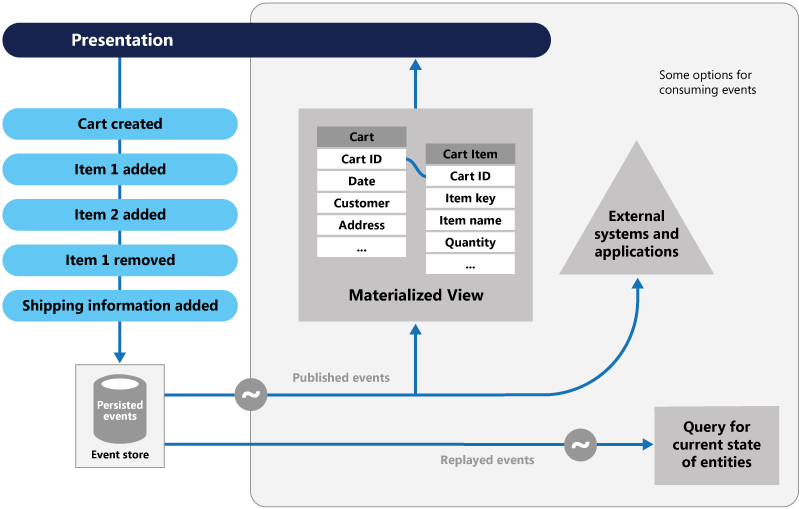


### How does it work?

You push an operation into the system, then, when you want to see the more recent operations you get the last inputted state of the system. 

###  But Why Tho?

* When a lot of things are touching the same object 
    * It acts a lot like MVCC (Multi-version concurrency control) for normal software.
    * Basically software can see the last version of an activity while new things are being appended on.
* You need to have an audit trail.
    * When you want to step through a sequence of events that have happened historically (hint: backtesting and portfolio tracking)



**Jamboree is an Event Souring system that's evolved into a general data management system.**

There are different components for different needs:

1. **Event sourcing** - Used to handle generic bits of information such as portfolio management or order
2. **File Storage** - Uses versioning with file blobs and for things like machine learning models, or strategies, or any other thing that needs to remain as a blob. Usually pickled objects you'd want to use later.
3. **Search** - This would be a replacement for SQL. Only it's not nearly as **traceable** as SQL. You can do just as many SQL like operations, only you can add full-text search with geolocational properties too.

## What is this?

*This is a tutorial showing you how to use **Jamboree**, and why things are the way the way they are.*


We're showing you how to use the library by managing orders. Let's get to it.

We're going to show the core functionality of jamboree:

1. Event Sourcing
    * The operations we use.
2. Single connection abstraction (processor). 
    * We're going to talk about it later.

Less text, more code.

In [1]:
from jamboree import Jamboree, DBHandler # This is how we connect to databases and outside systems
import pandas as pd
import uuid

In [2]:
import time

In [3]:
from jamboree.utils.core import consistent_hash

In [4]:
# Handlers are ways to manage events and everything related to events. 
# They abstract all of the push and pull operations

class OrderHandler(DBHandler):
    def __init__(self):
        # We totally need to call this. Don't forget to do it.
        super().__init__()
        # The code base checks for these fields prior to any insert operations
        # They're also used to generate a key. A key is like a lane where we append events in a sorted manner.
        # This is also useful when you need information for other parts of the system, such as to keep track of time.
        self.entity = "orders" # An entity is a name of a real world distinguishable object
        self.required = {
            "exchange": str,
            "broker": str,
            "user_id": str,
            "episode": str,
            "live": bool
        }
        self._is_event = False
        self.order_fields = ['status', 'price', 'amount']
    
    @property
    def current_time(self):
        return time.time()

    def is_valid_order(self, _order:dict):
        return all(field in _order.keys() for field in self.order_fields)
    
    def save_order(self, order:dict):
        """ Saves order information """
        if not self.is_valid_order(order):
            return
        _total = order['price'] * order['amount']
        order['total'] = _total
        order['time'] = self.current_time - 240000
        order['timestamp'] = self.current_time - 170000
        self.save(order)
        

## Notes to consider

We just saw how to create a handler. It has only one function. Which is to save an order. All of the other functions we'd use are baked into the jamboree library. Let's go through them, shall we?

In [5]:
main_processor = Jamboree() # We make a connection once and inject it into these objects. 
# We inject the code into a handler to not recreate connections. It saves memory and potential networking issues.

In [6]:
# Initialize and set required information. 
# Required information is really necessary to create a key. We check for this information using inbuilt functions. 
# One is save.
order_management = OrderHandler()
order_management['exchange'] = "exchange_name"
order_management['broker'] = "broker_name"
order_management['user_id'] = "example_user_id"
# order_management['episode'] = "example_episodes"
order_management['live'] = False
order_management.check() # this is called internally

AttributeError: episode is not in the requirements

In [7]:
order_management = OrderHandler()
order_management.processor = main_processor
order_management['exchange'] = "exchange_name"
order_management['broker'] = "broker_name"
order_management['user_id'] = "example_user_iddd"
order_management['episode'] = uuid.uuid4().hex
order_management['live'] = False
order_management.save_order({"price": 1205.0, "amount": 2, "status": "OPEN"})

In [8]:
all_orders = order_management.many()

In [9]:
all_orders

[{'exchange': 'exchange_name',
  'broker': 'broker_name',
  'user_id': 'example_user_iddd',
  'episode': '711c6b84e7dd414f8684caca0117c37b',
  'live': False,
  'type': 'orders',
  'mtype': 'event',
  'price': 1205.0,
  'amount': 2,
  'status': 'OPEN',
  'total': 2410.0,
  'time': 1587566626.3719652,
  'timestamp': 1587396624.0781157}]

In [10]:
order_frame = pd.DataFrame(all_orders)

In [11]:
order_frame

exchange       broker            user_id  \
0  exchange_name  broker_name  example_user_iddd   

                            episode   live    type  mtype   price  amount  \
0  711c6b84e7dd414f8684caca0117c37b  False  orders  event  1205.0       2   

  status   total          time     timestamp  
0   OPEN  2410.0  1.587567e+09  1.587397e+09

### What we just did

We just stored an event. Saying that we've added an order. All we called was `save_order`, and we were able to populate the database with that single event. We currently `self._is_event` set to false. That means we won't store duplicate information. We do this by adding an `episode_id`.

In [13]:
# order_frame = order_frame.drop(columns=['mtype'])

In [14]:
# order_frame.time = pd.to_datetime(order_frame.time, unit='s') 

In [15]:
# order_frame.timestamp = pd.to_datetime(order_frame.timestamp, unit='s') 

In [16]:
order_frame

exchange       broker            user_id  \
0  exchange_name  broker_name  example_user_iddd   

                            episode   live    type  mtype   price  amount  \
0  952787d3544c40c8bc7a35f840175002  False  orders  event  1205.0       2   

  status   total          time     timestamp  
0   OPEN  2410.0  1.587269e+09  1.587099e+09

In [17]:
order_management.save_order({"price": 1205.0, "amount": 2, "status": "CANCELLED"})

In [18]:
# all_orders = order_management.many()
# order_frame = pd.DataFrame(all_orders)
# order_frame = order_frame.drop(columns=['mtype'])
# order_frame.time = pd.to_datetime(order_frame.time, unit='s') 
# order_frame.timestamp = pd.to_datetime(order_frame.timestamp, unit='s') 

In [19]:
order_frame

exchange       broker            user_id  \
0  exchange_name  broker_name  example_user_iddd   

                            episode   live    type  mtype   price  amount  \
0  952787d3544c40c8bc7a35f840175002  False  orders  event  1205.0       2   

  status   total          time     timestamp  
0   OPEN  2410.0  1.587269e+09  1.587099e+09

In [20]:
order_management.save_order({"price": 1205.0, "amount": 2, "status": "CLOSED"})

In [21]:
# def get_all_orders():
#     all_orders = order_management.many(ar="relative")
#     order_frame = pd.DataFrame(all_orders)
#     _to_datetime = pd.to_datetime(order_frame.time, unit='s')
#     order_frame = order_frame.drop(columns=['mtype', 'user_id', "broker", "exchange", "live", "timestamp", "episode", "time"])
#     order_frame.set_index(_to_datetime, inplace=True)
#     return order_frame

In [22]:
# get_all_orders()

## What just happened?

We appended events to a single key inside of redis. Each event is stored to both an absolute time (the time in which we stored the information), and a relative time (the time we're referring to). This is useful when dealing with backtests. We can refer to times inside of the database and link them together. 

* We're now able to have an event log of the order. 
* This becomes really useful when we want to see how things have changed over time.
* Questions like:
    * What were the steps to completion?
    * What time did it take?
    * What percentage of the trade was completed per minute?
Our order logs can help us answer that. In case we need to query information we have **search functionality**, which replaces SQL. Search here would tell us information about the current state of things, but the event store would be able to tell us exactly what happened, in which order, and what time.


The next steps will be showing how to use some other functions inside of the `DBHandler`. We're going to 

* Set some insertion rules to ordering
* See if we can find orders throughout the system using search.
* We're also going to embed the dataframe logic directly into the class. 

Creating the OrderHandler again, but adding some parts to it.

In [12]:
# Handlers are ways to manage events and everything related to events. 
# They abstract all of the push and pull operations

class OrderHandler(DBHandler):
    def __init__(self):
        # We totally need to call this. Don't forget to do it.
        super().__init__()
        # The code base checks for these fields prior to any insert operations
        # They're also used to generate a key. A key is like a lane where we append events in a sorted manner.
        # This is also useful when you need information for other parts of the system, such as to keep track of time.
        self.entity = "orders" # An entity is a name of a real world distinguishable object
        self.required = {
            "exchange": str,
            "broker": str,
            "user_id": str,
            "episode": str,
            "live": bool
        }
        self._is_event = False
        self.order_fields = ['status', 'price', 'amount']
        self.allowed_statuses = ["OPEN", "PARTIAL", "FILLED", "CANCELLED"]
        self.order_status_paths = {
            "OPEN": ["PARTIAL", "FILLED", "CANCELLED"],
            "PARTIAL": ["FILLED", "CANCELLED"]
        }
        self.transistionable = ["OPEN", "PARTIAL"]
    
    @property
    def history(self):
        """ Returns a list of all the last 500 orders with this specific profile in a dataframe """
        all_orders = self.many(ar="relative")
        if len(all_orders) == 0:
            return []
        order_frame = pd.DataFrame(all_orders)
        _to_datetime = pd.to_datetime(order_frame.time, unit='s')
        order_frame = order_frame.drop(columns=['mtype', 'user_id', "broker", "exchange", "live", "timestamp", "episode", "time"])
        order_frame.set_index(_to_datetime, inplace=True)
        return order_frame
    
    @property
    def open_orders_spec(self):
        """ Get all open orders by exchange, broker, user_id, episode, live """
        pass
    
    @property
    def closed_orders_spec(self):
        """ Get all open orders by exchange, broker, user_id, episode, live """
        pass
    
    @property
    def current_time(self):
        return time.time()

    def is_valid_order(self, _order:dict):
        return all(field in _order.keys() for field in self.order_fields)
    
    def check_order_status(self, status:str, prior:str):
        if prior in self.transistionable:
            allowed_transitions = self.order_status_paths[prior]
            if status in allowed_transitions:
                return True
        return False
    
    def save_order(self, price:float, amount:float, status:str, order_number:int, order_id:str=None):
        """ Saves order information """
        self['order_num'] = order_number
        # Get the last order with that order number
        if status not in self.allowed_statuses:
            return
        """
            `self.last()`
        """ 
        previous_order = self.last()
        if len(previous_order.keys()) == 0:
            if status != "OPEN":
                print("New orders must be 'OPEN'")
                return
            order = {}
            _total = price * amount
            order['price'] = price
            order['amount'] = amount
            order['status'] = status
            order['total'] = _total
            order['time'] = self.current_time
            self.save(order)
            return
        
        prior_stat = previous_order.get('status')
        valid_prior = self.check_order_status(status, prior_stat)
        if valid_prior:
            order = {}
            _total = price * amount
            order['price'] = price
            order['amount'] = amount
            order['status'] = status
            order['total'] = _total
            order['time'] = self.current_time
            self.save(order)
        else:
            print("Not valid prior status")

In [13]:
episode_id = uuid.uuid4().hex

In [14]:
order_id = uuid.uuid4().hex

In [15]:
order_management = OrderHandler()
order_management.processor = main_processor
order_management['exchange'] = "exchange_name"
order_management['broker'] = "broker_name"
order_management['user_id'] = "example_user_iddd"
order_management['episode'] = episode_id
order_management['live'] = False

order_management.save_order(price=1205.0, amount=2, status="OPEN", order_number=1)

In [16]:
order_management.save_order(price=1205.0, amount=2, status="CANCELLED", order_number=1)

In [17]:
order_management.history

type  order_num   price  amount     status  \
time                                                                          
2020-04-22 14:44:48.020745516  orders          1  1205.0       2       OPEN   
2020-04-22 14:44:49.641817093  orders          1  1205.0       2  CANCELLED   

                                total  
time                                   
2020-04-22 14:44:48.020745516  2410.0  
2020-04-22 14:44:49.641817093  2410.0

In [82]:
order_management.save_order(price=1205.0, amount=2, status="OPEN", order_number=2)

In [83]:
order_management.save_order(price=1205.0, amount=2, status="FILLED", order_number=2)

In [108]:
order_management['order_num'] = 2
order_management.history

type  order_num   price  amount  status  \
time                                                                       
2020-04-19 18:20:23.322384834  orders          2  1205.0       2    OPEN   
2020-04-19 18:20:24.841871023  orders          2  1205.0       2  FILLED   

                                total  
time                                   
2020-04-19 18:20:23.322384834  2410.0  
2020-04-19 18:20:24.841871023  2410.0

## BUT WAIT!!!!

You're probably asking. "Wouldn't I be controlling multiple orders?" Short answer, yes. While event sourcing allows one to track orders over time, we would end up tracking multiple orders.

Event sourcing is column based. It's ultimately focused on

To track multiple orders, we'd track order by order number, and duplicate the present order state in search. 


If we're trying to get the exact order we'd essentially use search to store and receieve the present state of orders. Asking something like:

1. Find all open orders for this user
2. Find all closed orders for this user
3. Find all closed orders and its history

Wouldn't take too much time hopefully.


Search doesn't work too differently from the event sourcing. Currently prototyping some new features in an abstraction called `PrototypeSearchFeatures`. We're going to show how it works.

In [20]:
from see137.search import PrototypeSearchFeatures

ModuleNotFoundError: No module named 'see137'

In [19]:
class OrderSearch(PrototypeSearchFeatures):
    """ 
        # Core Backtest Search  

        Use to find backtesting information.

        Examples:

        ```py

            order_search.create(**kwargs)

        ```
    """

    # Backtesting is basically a
    def __init__(self):
        super().__init__()
        self.entity = "orders"
        """
            
            
        """
        self.dreq = {
#             "exchange": str,
            "broker": str,
            "user_id": str,
            "episode": str,
            "live": bool,
            "order_num": int,
            "price": float,
            "amount": float,
            "total": float,
            "status": str
        }
        self.must_have = [
            'exchange',
            'broker',
            'user_id',
            'episode',
            'live',
            'order_num'
        ]
        

NameError: name 'PrototypeSearchFeatures' is not defined

In [88]:
userid = uuid.uuid4().hex
episodeid = uuid.uuid4().hex

In [18]:

order_search = OrderSearch()
order_search.processor = main_processor
order_search.Create(
    no_overwrite_reqs=True, 
    exchange="binance", 
    broker="alpine", 
    user_id=userid, 
    episode=episodeid, 
    live=False, 
    order_num=1, 
    price=100.0,
    status="OPEN",
    amount=1,
    total=100.0
)

NameError: name 'OrderSearch' is not defined

# What search just did
Search returns an id that represets where that record is inside of the search database

In [110]:
order_search.Find(episode=episodeid)

[{'id': 'd1dc07ea4ca4481481381ed0c088bad6',
  'exchange': 'binance',
  'broker': 'alpine',
  'user_id': '78cc007d29f0425f90e1990f07a216a3',
  'episode': '6b6ec5b4da3844dc8ad43375908a4659',
  'live': 'FALSE',
  'order_num': '1',
  'entity': 'orders',
  'price': '100.0',
  'status': 'OPEN',
  'amount': '1',
  'total': '100.0'}]

In [112]:
order_search.Find("*")

[{'id': 'd1dc07ea4ca4481481381ed0c088bad6',
  'exchange': 'binance',
  'broker': 'alpine',
  'user_id': '78cc007d29f0425f90e1990f07a216a3',
  'episode': '6b6ec5b4da3844dc8ad43375908a4659',
  'live': 'FALSE',
  'order_num': '1',
  'entity': 'orders',
  'price': '100.0',
  'status': 'OPEN',
  'amount': '1',
  'total': '100.0'}]

In [113]:
order_search.Create(
    no_overwrite_reqs=True, 
    exchange="binance", 
    broker="alpine", 
    user_id=uuid.uuid4().hex, 
    episode=episodeid, 
    live=False, 
    order_num=1, 
    price=100.0,
    status="OPEN",
    amount=1,
    total=100.0
)

'e1020cf272dc4c06bd7a72e88eab997d'

In [114]:
order_search.Find(user_id=userid)

[{'id': 'd1dc07ea4ca4481481381ed0c088bad6',
  'exchange': 'binance',
  'broker': 'alpine',
  'user_id': '78cc007d29f0425f90e1990f07a216a3',
  'episode': '6b6ec5b4da3844dc8ad43375908a4659',
  'live': 'FALSE',
  'order_num': '1',
  'entity': 'orders',
  'price': '100.0',
  'status': 'OPEN',
  'amount': '1',
  'total': '100.0'}]

In [115]:
order_search.Find("*")

[{'id': 'e1020cf272dc4c06bd7a72e88eab997d',
  'exchange': 'binance',
  'broker': 'alpine',
  'user_id': 'e7cd76e0be0947909acbf86a794a8c7b',
  'episode': '6b6ec5b4da3844dc8ad43375908a4659',
  'live': 'FALSE',
  'order_num': '1',
  'entity': 'orders',
  'price': '100.0',
  'status': 'OPEN',
  'amount': '1',
  'total': '100.0'},
 {'id': 'd1dc07ea4ca4481481381ed0c088bad6',
  'exchange': 'binance',
  'broker': 'alpine',
  'user_id': '78cc007d29f0425f90e1990f07a216a3',
  'episode': '6b6ec5b4da3844dc8ad43375908a4659',
  'live': 'FALSE',
  'order_num': '1',
  'entity': 'orders',
  'price': '100.0',
  'status': 'OPEN',
  'amount': '1',
  'total': '100.0'}]

## Where this is useful

Search is ultimately going to be used to sort through information. Meanwhile, the event source will be used to look through histories of a given bit of information. Where search will be used to ask questions like:


1. Find all of the open orders by (userid, episode, etc)



Event sourcing will be able to ask questions like. Get me the history of all of the orders for this particular bit of information.